# Imports and WandB



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import wandb 
import os

# Ensure the user is logged into wandb. You might need to run `wandb login` in your terminal.
if os.getenv('WANDB_API_KEY') is None:
    print("Warning: W&B API key not found. Please log in using 'wandb login' in your terminal.")


## Wandb Test Run

In [6]:
import random

import wandb

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    # Set the wandb project where this run will be logged.
    project="my-awesome-project",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": 10,
    },
)

# Simulate training.
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset

    # Log metrics to wandb.
    run.log({"acc": acc, "loss": loss})

# Finish the run and upload any remaining data.
run.finish()

acc,▁▃▄▇▆██▇
loss,█▇▃▃▁▁▁▁
acc,0.89135
loss,0.11653


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# CNN

In [9]:
USERNAME = "sudershan.sarraf" # <--- EDIT THIS

#
# ---> Setup device for GPU/CPU training <--- #
#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#
# ---> Pre-calculated mean and std for Fashion-MNIST for normalization <--- #
#
FASHION_MNIST_MEAN = 0.2860
FASHION_MNIST_STD = 0.3530

#
# ---> Part 0: GPU Sanity Check <--- #
#
def check_gpu():
    """
    Prints GPU status and performs a test operation.
    """
    print("--- GPU Sanity Check ---")
    if torch.cuda.is_available():
        print(f"Device: {device}")
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
        
        # Create two tensors and send them to the GPU
        try:
            x_gpu = torch.rand(5, 5).to(device)
            y_gpu = torch.rand(5, 5).to(device)
            
            # Perform a matrix multiplication on the GPU
            start_time = time.time()
            z_gpu = torch.matmul(x_gpu, y_gpu)
            torch.cuda.synchronize() # Wait for the operation to complete
            end_time = time.time()
            
            print(f"Test GPU operation (5x5 matmul) successful in {(end_time - start_time) * 1000:.4f} ms")
            print("Result tensor is on:", z_gpu.device)
            
        except Exception as e:
            print(f"GPU test operation FAILED: {e}")
    else:
        print("Device: CPU. No GPU (CUDA) detected by PyTorch.")
    print("--------------------------\n")

#
# ---> Part 1: Data Loading & Preprocessing <--- #
#
class FashionMNISTMultiTask(Dataset):
    """
    Custom Dataset for Fashion-MNIST.
    Returns a tuple: (image, class_label, ink_target)
    - image: Normalized tensor for the model.
    - class_label: The standard integer label (0-9).
    - ink_target: The normalized average pixel value of the image (for regression).
    """
    def __init__(self, root, train=True, transform=None, download=True):
        # Load the base FashionMNIST dataset
        self.base_dataset = datasets.FashionMNIST(root=root, train=train, download=download)
        self.transform = transform
        # We need a simple ToTensor transform to calculate ink from the raw image
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Get the raw PIL image and its label
        image, class_label = self.base_dataset[idx]

        # Convert image to a tensor with values in [0, 1] to calculate the ink target
        img_tensor_for_ink = self.to_tensor(image)
        ink_target = img_tensor_for_ink.mean() # Calculate average pixel intensity

        # Apply the full transformation pipeline (augmentations, normalization) for the model input
        if self.transform:
            image = self.transform(image)
        else:
            # If no other transform is specified, use the basic tensor
            image = img_tensor_for_ink

        return image, class_label, ink_target.float()

#
# ---> Define data transformations and augmentations <--- #
#
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((FASHION_MNIST_MEAN,), (FASHION_MNIST_STD,))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((FASHION_MNIST_MEAN,), (FASHION_MNIST_STD,))
])

#
# ---> Create datasets and dataloaders <--- #
#
print("Loading and preparing datasets...")
# Load the training data using our custom dataset class
full_train_dataset = FashionMNISTMultiTask(
    root='./data',
    train=True,
    transform=train_transform,
    download=True
)

# Load the test data
test_dataset_custom = FashionMNISTMultiTask(
    root='./data', 
    train=False, 
    transform=val_test_transform,
    download=True
)

# Split the full training set into training and validation sets (90/10 split)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# IMPORTANT: Set the validation set's transform to NOT use augmentations
# We create a new object wrapper to be 100% sure
class ValDatasetWrapper(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, idx):
        # Get data from the original subset
        image, class_label, ink_target = self.subset[idx]
        
        # We must re-apply the ToTensor and Normalize, as the subset
        # will return the *augmented* image.
        # To fix this, we'll get the raw data from the base dataset.
        original_idx = self.subset.indices[idx]
        image_pil, class_label_orig = self.subset.dataset.base_dataset[original_idx]
        
        # Apply the correct validation transform
        image_tensor = self.transform(image_pil)
        
        # Recalculate ink target (it won't change, but good to be consistent)
        ink_target_orig = self.subset.dataset.to_tensor(image_pil).mean()
        
        return image_tensor, class_label_orig, ink_target_orig.float()

    def __len__(self):
        return len(self.subset)

# Re-wrap the validation dataset
val_dataset = ValDatasetWrapper(val_dataset, val_test_transform)
print("Datasets created and split.\n")

#
# ---> Part 2: Model Architecture <--- #
#
class MultiTaskCNN(nn.Module):
    """
    A CNN with a shared backbone and two heads for classification and regression.
    """
    def __init__(self, dropout_rate=0.25):
        super(MultiTaskCNN, self).__init__()

        # Shared convolutional backbone
        self.backbone = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),

            # Block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate)
        )

        # The output of the backbone will be of size (batch, 64, 7, 7)
        # We flatten it to a vector of size 64 * 7 * 7 = 3136
        self.flatten = nn.Flatten()

        # Head 1: Classification
        self.classification_head = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10) # 10 output classes
        )

        # Head 2: Regression
        self.regression_head = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 1) # 1 scalar output
        )

    def forward(self, x):
        # Pass input through the shared backbone
        features = self.backbone(x)
        features = self.flatten(features)

        # Get predictions from both heads
        class_logits = self.classification_head(features)
        regression_output = self.regression_head(features)

        return class_logits, regression_output

#
# ---> Part 3: Training and Evaluation Functions <--- #
#

def run_experiment(config):
    """
    Initializes wandb and runs a full training and evaluation experiment.
    """
    # Initialize a new wandb run
    # 'reinit=True' allows us to call this function multiple times in one script
    with wandb.init(project="smai-a4-q1-fashion-mnist", config=config, reinit=True) as run:
        config = run.config # Get the config from wandb

        # --- 1. DataLoaders ---
        train_loader = DataLoader(
            train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        # --- 2. Model, Loss, and Optimizer ---
        model = MultiTaskCNN(dropout_rate=config.dropout_rate).to(device)
        run.watch(model, log='all', log_freq=100) # Log gradients and model architecture

        # Loss functions
        criterion_classification = nn.CrossEntropyLoss()
        criterion_regression = nn.MSELoss()

        # Optimizer
        if config.optimizer == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
        else: # AdamW
            optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
            
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2)

        # --- 3. Training Loop ---
        print(f"\n--- Starting Run: {run.name} ---")
        best_val_loss = float('inf')
        
        for epoch in range(config.epochs):
            # Training step
            model.train()
            train_loss_total, train_loss_ce, train_loss_mse = 0, 0, 0
            for images, labels, inks in train_loader:
                images, labels, inks = images.to(device), labels.to(device), inks.to(device)

                optimizer.zero_grad()
                class_logits, reg_outputs = model(images)

                loss_ce = criterion_classification(class_logits, labels)
                loss_mse = criterion_regression(reg_outputs.squeeze(), inks)

                # Calculate joint loss
                total_loss = (config.lambda_1 * loss_ce) + (config.lambda_2 * loss_mse)

                total_loss.backward()
                optimizer.step()

                train_loss_total += total_loss.item()
                train_loss_ce += loss_ce.item()
                train_loss_mse += loss_mse.item()

            # --- 4. Validation Step ---
            model.eval()
            val_loss_total, val_loss_ce, val_loss_mse = 0, 0, 0
            correct, total_samples = 0, 0
            all_reg_preds, all_inks = [], []

            with torch.no_grad():
                for images, labels, inks in val_loader:
                    images, labels, inks = images.to(device), labels.to(device), inks.to(device)
                    class_logits, reg_outputs = model(images)

                    # Calculate validation loss
                    loss_ce = criterion_classification(class_logits, labels)
                    loss_mse = criterion_regression(reg_outputs.squeeze(), inks)
                    total_loss = (config.lambda_1 * loss_ce) + (config.lambda_2 * loss_mse)
                    val_loss_total += total_loss.item()
                    val_loss_ce += loss_ce.item()
                    val_loss_mse += loss_mse.item()

                    # Calculate validation metrics
                    _, predicted = torch.max(class_logits.data, 1)
                    total_samples += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    all_reg_preds.extend(reg_outputs.squeeze().cpu().numpy())
                    all_inks.extend(inks.cpu().numpy())

            # Calculate metrics
            avg_val_loss = val_loss_total / len(val_loader)
            val_accuracy = 100 * correct / total_samples
            val_mae = np.mean(np.abs(np.array(all_reg_preds) - np.array(all_inks)))
            val_rmse = np.sqrt(np.mean((np.array(all_reg_preds) - np.array(all_inks))**2))
            
            scheduler.step(avg_val_loss)

            # --- 5. Logging to wandb ---
            run.log({
                "epoch": epoch,
                "train/total_loss": train_loss_total / len(train_loader),
                "train/ce_loss": train_loss_ce / len(train_loader),
                "train/mse_loss": train_loss_mse / len(train_loader),
                "val/total_loss": avg_val_loss,
                "val/ce_loss": val_loss_ce / len(val_loader),
                "val/mse_loss": val_loss_mse / len(val_loader),
                "val/accuracy": val_accuracy,
                "val/mae": val_mae,
                "val/rmse": val_rmse,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
            
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"Epoch {epoch+1:02d}/{config.epochs} | "
                      f"Val Loss: {avg_val_loss:.4f} | "
                      f"Val Acc: {val_accuracy:.2f}% | "
                      f"Val RMSE: {val_rmse:.4f}")
            
            # Save the best model based on validation loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                model_save_path = f"best_model_{run.id}.pth"
                torch.save(model.state_dict(), model_save_path)
                
        # Save the best model as a wandb artifact
        artifact = wandb.Artifact(f'model-{run.id}', type='model')
        artifact.add_file(model_save_path)
        run.log_artifact(artifact)
        
        print(f"--- Run {run.name} Finished. Best Val Loss: {best_val_loss:.4f} ---")
        
        # Return the path to the best model and its config
        return model_save_path, config

# Separate evaluation function for the final test
def evaluate_model(model, test_loader, device):
    """
    Evaluates a trained model on the test set and logs metrics to wandb.
    """
    model.to(device)
    model.eval()
    
    criterion_classification = nn.CrossEntropyLoss()
    criterion_regression = nn.MSELoss()
    
    test_loss_total, test_loss_ce, test_loss_mse = 0, 0, 0
    correct, total_samples = 0, 0
    all_reg_preds, all_inks = [], []

    with torch.no_grad():
        for images, labels, inks in test_loader:
            images, labels, inks = images.to(device), labels.to(device), inks.to(device)
            class_logits, reg_outputs = model(images)

            # Calculate loss
            loss_ce = criterion_classification(class_logits, labels)
            loss_mse = criterion_regression(reg_outputs.squeeze(), inks)
            # Use 1:1 weighting for final test eval, regardless of training lambdas
            total_loss = loss_ce + loss_mse
            
            test_loss_total += total_loss.item()
            test_loss_ce += loss_ce.item()
            test_loss_mse += loss_mse.item()

            # Calculate metrics
            _, predicted = torch.max(class_logits.data, 1)
            total_samples += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_reg_preds.extend(reg_outputs.squeeze().cpu().numpy())
            all_inks.extend(inks.cpu().numpy())

    # Calculate final metrics
    test_accuracy = 100 * correct / total_samples
    test_mae = np.mean(np.abs(np.array(all_reg_preds) - np.array(all_inks)))
    test_rmse = np.sqrt(np.mean((np.array(all_reg_preds) - np.array(all_inks))**2))

    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")

    # Log metrics to the active wandb run
    wandb.log({
        "test/accuracy": test_accuracy,
        "test/mae": test_mae,
        "test/rmse": test_rmse,
        "test/ce_loss": test_loss_ce / len(test_loader),
        "test/mse_loss": test_loss_mse / len(test_loader)
    })
    
#
# ---> Part 4: Feature Map Visualization Functions <--- #
#
def get_feature_maps(model, layer_name, input_image):
    """
    Extracts feature maps from a specified layer of the model using hooks.
    """
    feature_maps = {}
    def hook_fn(module, input, output):
        feature_maps[layer_name] = output.detach()

    handle = None
    target_layer = dict(model.named_modules()).get(layer_name)
    
    if target_layer is None:
        print(f"Error: Layer {layer_name} not found in model.")
        print("Available layers:")
        for name, _ in model.named_modules():
            print(name)
        return None
        
    handle = target_layer.register_forward_hook(hook_fn)

    model.eval()
    with torch.no_grad():
        model(input_image)

    handle.remove()
    return feature_maps.get(layer_name)


def visualize_feature_maps(feature_maps, num_cols=8, title=""):
    """
    Plots the feature maps in a grid and logs to wandb.
    """
    if feature_maps is None:
        return
        
    maps = feature_maps.squeeze(0)
    num_maps = maps.shape[0]
    num_rows = (num_maps + num_cols - 1) // num_cols

    fig = plt.figure(figsize=(num_cols * 2, num_rows * 2))
    fig.suptitle(title, fontsize=16)
    
    for i in range(num_maps):
        ax = fig.add_subplot(num_rows, num_cols, i + 1)
        ax.imshow(maps[i].cpu().numpy(), cmap='viridis')
        ax.axis('off')
        
        # Add username text as required by assignment
        ax.text(
            0.95, 0.95, USERNAME,
            ha='right', va='top', transform=ax.transAxes,
            fontsize=8, color='gray', alpha=0.7
        )
        
        ax.set_title(f'Map {i+1}')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Log the figure to wandb
    wandb.log({f"feature_maps/{title}": wandb.Image(plt)})
    plt.show()
    plt.close(fig) # Close the figure to save memory

#
# ---> Main Execution Block <--- #
#
if __name__ == '__main__':
    
    # Run the GPU check first
    check_gpu()

    #
    # ---> Part 4: Hyperparameter Tuning <--- #
    #
    
    # Define 5 distinct configurations as required
    config_1 = {
        "learning_rate": 0.001, "optimizer": "adam", "epochs": 15, "batch_size": 128,
        "dropout_rate": 0.3, "lambda_1": 1.0, "lambda_2": 1.0, "name": "Run_1_Balanced_1_1"
    }
    config_2 = {
        "learning_rate": 0.001, "optimizer": "adam", "epochs": 15, "batch_size": 128,
        "dropout_rate": 0.3, "lambda_1": 2.0, "lambda_2": 1.0, "name": "Run_2_Class_Focus_2_1"
    }
    config_3 = {
        "learning_rate": 0.001, "optimizer": "adam", "epochs": 15, "batch_size": 128,
        "dropout_rate": 0.3, "lambda_1": 1.0, "lambda_2": 2.0, "name": "Run_3_Reg_Focus_1_2"
    }
    config_4 = {
        "learning_rate": 0.0005, "optimizer": "adamw", "epochs": 15, "batch_size": 64,
        "dropout_rate": 0.4, "lambda_1": 1.0, "lambda_2": 1.0, "name": "Run_4_AdamW_LowerLR"
    }
    config_5 = {
        "learning_rate": 0.01, "optimizer": "sgd", "epochs": 15, "batch_size": 128,
        "dropout_rate": 0.3, "lambda_1": 1.0, "lambda_2": 1.0, "name": "Run_5_SGD_HighLR"
    }

    configs = [config_1, config_2, config_3, config_4, config_5]
    best_model_paths = [] # To store paths of saved models

    for config in configs:
        model_path, model_config = run_experiment(config)
        best_model_paths.append((model_path, model_config))

    #
    # ---> Part 5: Final Evaluation & Visualization <--- #
    #
    
    # *FIX*: Start a new, separate wandb run for the final analysis.
    # This ensures wandb.log() has an active run to log to.
    print("\n\n--- Starting Final Evaluation and Visualization Run ---")
    with wandb.init(project="smai-a4-q1-fashion-mnist", name="Final_Analysis", job_type="analysis") as final_run:
        
        # Create a single test loader
        test_loader = DataLoader(
            test_dataset_custom,
            batch_size=128,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        # --- Model Selection ---
        # NOTE: You should check your wandb dashboard to find the *actual*
        # best runs for classification and regression.
        # For this script, we'll just evaluate all 5 models as an example.
        
        print("\n--- Evaluating all 5 trained models on the TEST set ---")
        
        for i, (model_path, config) in enumerate(best_model_paths):
            print(f"\nEvaluating Model from {config.get('name', f'Run {i+1}')} (File: {model_path})...")
            
            # Initialize a new model instance and load the saved weights
            model = MultiTaskCNN(dropout_rate=config['dropout_rate'])
            model.load_state_dict(torch.load(model_path, map_location=device))
            
            # Log which model this is
            wandb.log({"evaluating_model": config.get('name', f'Run {i+1}')})
            evaluate_model(model, test_loader, device)

        #
        # ---> Part 6: Feature Map Visualization <--- #
        #
        
        print("\n\n--- Visualizing Feature Maps ---")
        
        # We'll use the model from Run 1 (Balanced) for visualization
        # You can change this to any model you want
        model_1_path, config_1 = best_model_paths[0]
        print(f"Loading model {config_1.get('name')} for visualization...")
        
        vis_model = MultiTaskCNN(dropout_rate=config_1['dropout_rate'])
        vis_model.load_state_dict(torch.load(model_1_path, map_location=device))
        vis_model.to(device)

        # Get 3 test images
        # We re-create a loader with shuffle=True to get random images
        viz_loader = DataLoader(test_dataset_custom, batch_size=3, shuffle=True)
        images, labels, inks = next(iter(viz_loader))
        
        class_names = [
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]

        for i in range(3):
            sample_image = images[i].unsqueeze(0).to(device)
            sample_label = class_names[labels[i].item()]
            
            print(f"\nVisualizing for Image {i+1} (Label: {sample_label})")
            
            # Log the original image
            wandb.log({f"original_image_{i+1}": wandb.Image(sample_image, caption=f"Label: {sample_label}")})

            # Visualize feature maps from the first and second conv blocks
            # Layer names come from `model.named_modules()`
            # 'backbone.0' is the first Conv2d layer
            # 'backbone.5' is the second Conv2d layer
            
            maps_conv1 = get_feature_maps(vis_model, 'backbone.0', sample_image)
            visualize_feature_maps(maps_conv1, num_cols=8, title=f"Image_{i+1}_{sample_label}_Block1_Features")
            
            maps_conv2 = get_feature_maps(vis_model, 'backbone.5', sample_image)
            visualize_feature_maps(maps_conv2, num_cols=8, title=f"Image_{i+1}_{sample_label}_Block2_Features")
            
        print("\n--- Final Analysis Run Finished ---")



Loading and preparing datasets...
Datasets created and split.

--- GPU Sanity Check ---
Device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
GPU test operation FAILED: name 'time' is not defined
--------------------------




--- Starting Run: vivid-darkness-8 ---
Epoch 01/15 | Val Loss: 0.5263 | Val Acc: 81.83% | Val RMSE: 0.1543
Epoch 05/15 | Val Loss: 0.3379 | Val Acc: 87.82% | Val RMSE: 0.1255
Epoch 10/15 | Val Loss: 0.2802 | Val Acc: 90.30% | Val RMSE: 0.1255
Epoch 15/15 | Val Loss: 0.2556 | Val Acc: 91.05% | Val RMSE: 0.1255
--- Run vivid-darkness-8 Finished. Best Val Loss: 0.2556 ---


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/ce_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val/accuracy,▁▃▄▆▆▅▆▇▇▇▆▇▇██
val/ce_loss,█▆▅▃▃▃▂▂▂▂▃▂▁▁▁
val/mae,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/rmse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...



--- Starting Run: daily-glade-9 ---
Epoch 01/15 | Val Loss: 1.0142 | Val Acc: 81.53% | Val RMSE: 0.1727
Epoch 05/15 | Val Loss: 0.6896 | Val Acc: 87.15% | Val RMSE: 0.1255
Epoch 10/15 | Val Loss: 0.5836 | Val Acc: 89.37% | Val RMSE: 0.1255
Epoch 15/15 | Val Loss: 0.5027 | Val Acc: 90.92% | Val RMSE: 0.1255
--- Run daily-glade-9 Finished. Best Val Loss: 0.5027 ---


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/ce_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val/accuracy,▁▄▅▅▅▆▇▇▇▇▇▇███
val/ce_loss,█▅▄▄▄▃▂▂▂▂▂▂▁▁▁
val/mae,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/rmse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...



--- Starting Run: exalted-plasma-10 ---
Epoch 01/15 | Val Loss: 0.5707 | Val Acc: 81.30% | Val RMSE: 0.1545
Epoch 05/15 | Val Loss: 0.3366 | Val Acc: 87.70% | Val RMSE: 0.0305
Epoch 10/15 | Val Loss: 0.2878 | Val Acc: 89.23% | Val RMSE: 0.0274
Epoch 15/15 | Val Loss: 0.2669 | Val Acc: 90.02% | Val RMSE: 0.0284
--- Run exalted-plasma-10 Finished. Best Val Loss: 0.2669 ---


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/ce_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
train/mse_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
val/accuracy,▁▄▄▆▆▆▇▇▇▇█████
val/ce_loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁
val/mae,█▇▃▂▁▁▁▁▂▂▁▁▃▂▂
val/mse_loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁
val/rmse,█▇▃▂▂▁▁▁▂▁▁▁▂▂▁
+1,...



--- Starting Run: vocal-brook-11 ---
Epoch 01/15 | Val Loss: 0.4403 | Val Acc: 84.42% | Val RMSE: 0.0375
Epoch 05/15 | Val Loss: 0.3350 | Val Acc: 87.22% | Val RMSE: 0.0403
Epoch 10/15 | Val Loss: 0.2938 | Val Acc: 88.95% | Val RMSE: 0.0299
Epoch 15/15 | Val Loss: 0.2920 | Val Acc: 88.47% | Val RMSE: 0.0258
--- Run vocal-brook-11 Finished. Best Val Loss: 0.2646 ---


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,██████████████▁
train/ce_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val/accuracy,▁▂▄▅▅▆▆▇▇▇▇█▇▇▆
val/ce_loss,█▆▅▄▄▃▃▂▂▂▂▁▂▁▂
val/mae,▇▄▁▆█▄█▅▄▅▅▄▂▃▄
val/mse_loss,▇▃▁▅█▃█▄▃▄▄▃▁▃▃
val/rmse,▇▄▁▆█▄█▅▄▅▅▄▂▃▄
+1,...



--- Starting Run: soft-leaf-12 ---
Epoch 01/15 | Val Loss: 0.4678 | Val Acc: 82.00% | Val RMSE: 0.0527
Epoch 05/15 | Val Loss: 0.3156 | Val Acc: 88.10% | Val RMSE: 0.0262
Epoch 10/15 | Val Loss: 0.2767 | Val Acc: 89.82% | Val RMSE: 0.0224
Epoch 15/15 | Val Loss: 0.2525 | Val Acc: 90.45% | Val RMSE: 0.0336
--- Run soft-leaf-12 Finished. Best Val Loss: 0.2525 ---


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/ce_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val/accuracy,▁▃▆▅▆▆▆▆▇▇▇█▇██
val/ce_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▁▁
val/mae,█▂▆▆▂▃▅▁▆▁▅▄▃▆▄
val/mse_loss,█▂▅▅▂▂▄▁▄▁▄▃▃▅▃
val/rmse,█▂▅▅▂▃▅▁▅▁▅▄▃▆▄
+1,...




--- Starting Final Evaluation and Visualization Run ---



--- Evaluating all 5 trained models on the TEST set ---

Evaluating Model from Run_1_Balanced_1_1 (File: best_model_jlna4yuu.pth)...
Test Accuracy: 91.02%
Test MAE: 0.1051
Test RMSE: 0.1258

Evaluating Model from Run_2_Class_Focus_2_1 (File: best_model_nl92af41.pth)...
Test Accuracy: 90.62%
Test MAE: 0.1050
Test RMSE: 0.1258

Evaluating Model from Run_3_Reg_Focus_1_2 (File: best_model_314f6g16.pth)...
Test Accuracy: 89.91%
Test MAE: 0.0253
Test RMSE: 0.0286

Evaluating Model from Run_4_AdamW_LowerLR (File: best_model_0rlu1j9f.pth)...
Test Accuracy: 90.10%
Test MAE: 0.0203
Test RMSE: 0.0247

Evaluating Model from Run_5_SGD_HighLR (File: best_model_y3gn6yy5.pth)...
Test Accuracy: 89.94%
Test MAE: 0.0306
Test RMSE: 0.0337


--- Visualizing Feature Maps ---
Loading model Run_1_Balanced_1_1 for visualization...

Visualizing for Image 1 (Label: Sneaker)


Traceback (most recent call last):
  File "/tmp/ipykernel_1483/4285809493.py", line 587, in <module>
    wandb.log({f"original_image_{i+1}": wandb.Image(sample_image, caption=f"Label: {sample_label}")})
                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/blozerx/venvs/smai-env/lib/python3.12/site-packages/wandb/sdk/data_types/image.py", line 277, in __init__
    self._initialize_from_data(data_or_path, mode, file_type, normalize)
  File "/home/blozerx/venvs/smai-env/lib/python3.12/site-packages/wandb/sdk/data_types/image.py", line 417, in _initialize_from_data
    data = data.permute(1, 2, 0).cpu().numpy()  # type: ignore [union-attr]
           ^^^^^^^^^^^^^^^^^^^^^
RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3


test/accuracy,█▅▁▂▁
test/ce_loss,▁▄█▇▅
test/mae,██▁▁▂
test/mse_loss,██▁▁▁
test/rmse,██▁▁▂
evaluating_model,Run_5_SGD_HighLR
test/accuracy,89.94
test/ce_loss,0.26778
test/mae,0.03055
test/mse_loss,0.00114
test/rmse,0.03371


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

## Wandb - https://wandb.ai/sudersha-sarraf-iiit-hyderabad/smai-a4-q1-fashion-mnist?nw=nwusersudershasarraf


Device: cuda
Loading datasets...

Training best-config model (λ1=1.0, λ2=2.0)...
Epoch 01/15  train_loss=1.1644  val_loss=0.5700  val_acc=80.45%
Epoch 02/15  train_loss=0.5749  val_loss=0.4393  val_acc=84.50%
Epoch 03/15  train_loss=0.5096  val_loss=0.3896  val_acc=86.85%
Epoch 04/15  train_loss=0.4762  val_loss=0.3691  val_acc=87.40%
Epoch 05/15  train_loss=0.4569  val_loss=0.3604  val_acc=87.30%
Epoch 06/15  train_loss=0.4382  val_loss=0.3354  val_acc=88.92%
Epoch 07/15  train_loss=0.4260  val_loss=0.3380  val_acc=88.83%
Epoch 08/15  train_loss=0.4168  val_loss=0.3405  val_acc=88.52%
Epoch 09/15  train_loss=0.4091  val_loss=0.3136  val_acc=89.65%
Epoch 10/15  train_loss=0.3999  val_loss=0.3235  val_acc=89.25%
Epoch 11/15  train_loss=0.3936  val_loss=0.3092  val_acc=89.88%
Epoch 12/15  train_loss=0.3893  val_loss=0.3169  val_acc=89.25%
Epoch 13/15  train_loss=0.3787  val_loss=0.3007  val_acc=90.22%
Epoch 14/15  train_loss=0.3709  val_loss=0.2887  val_acc=90.67%
Epoch 15/15  train_loss

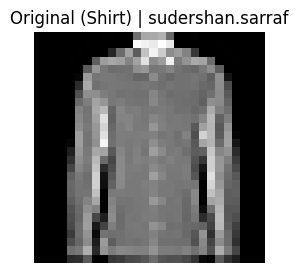

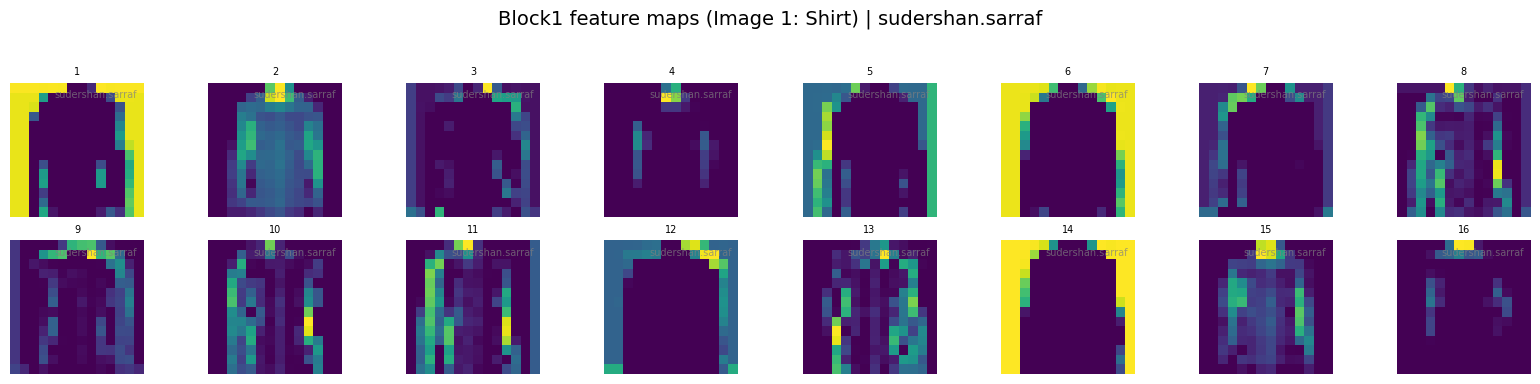

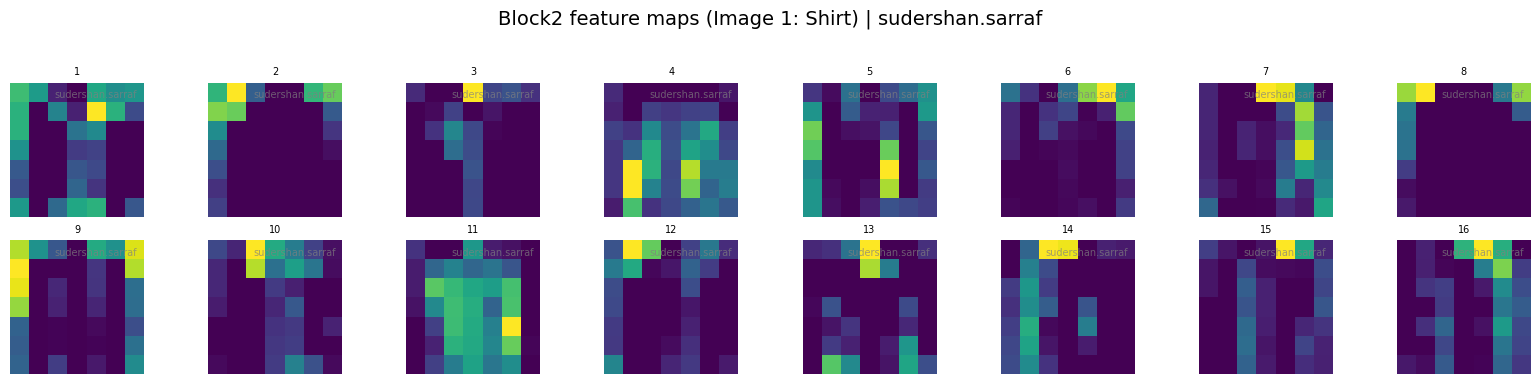


Image 2: Sneaker


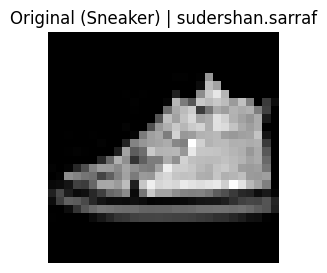

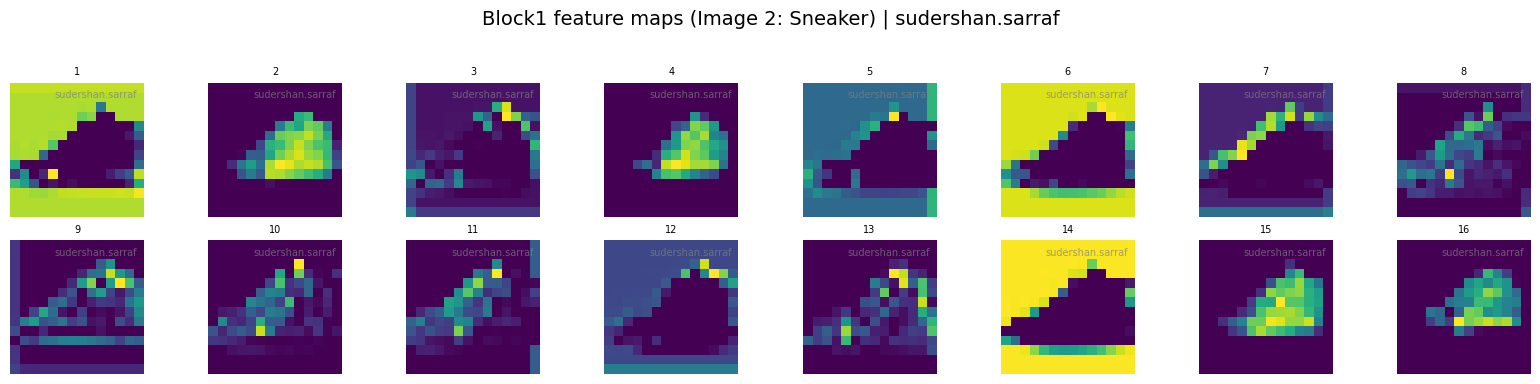

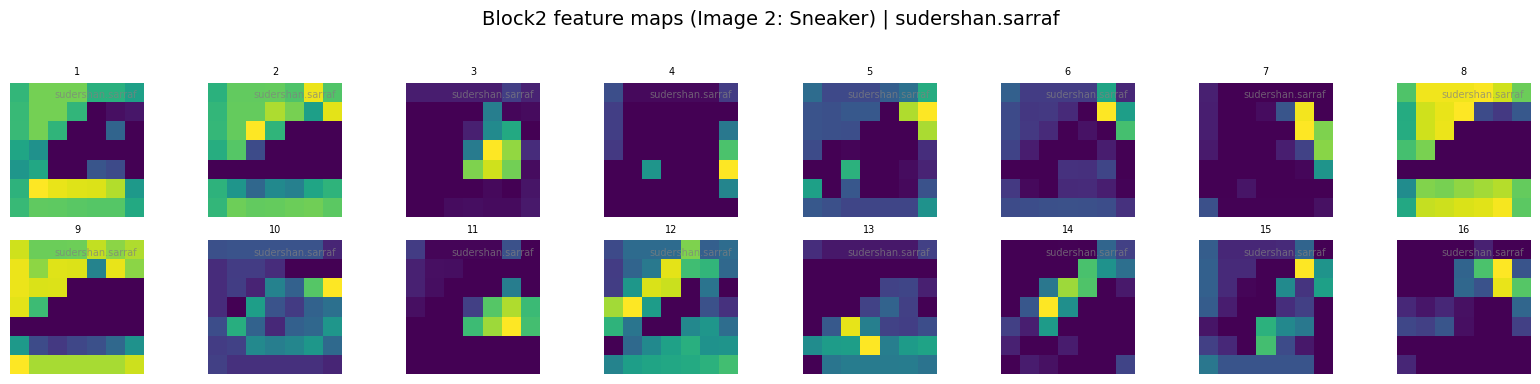


Image 3: Sneaker


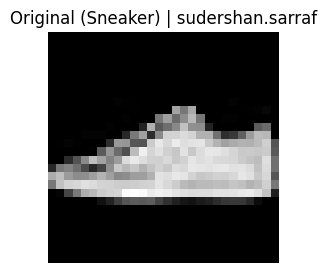

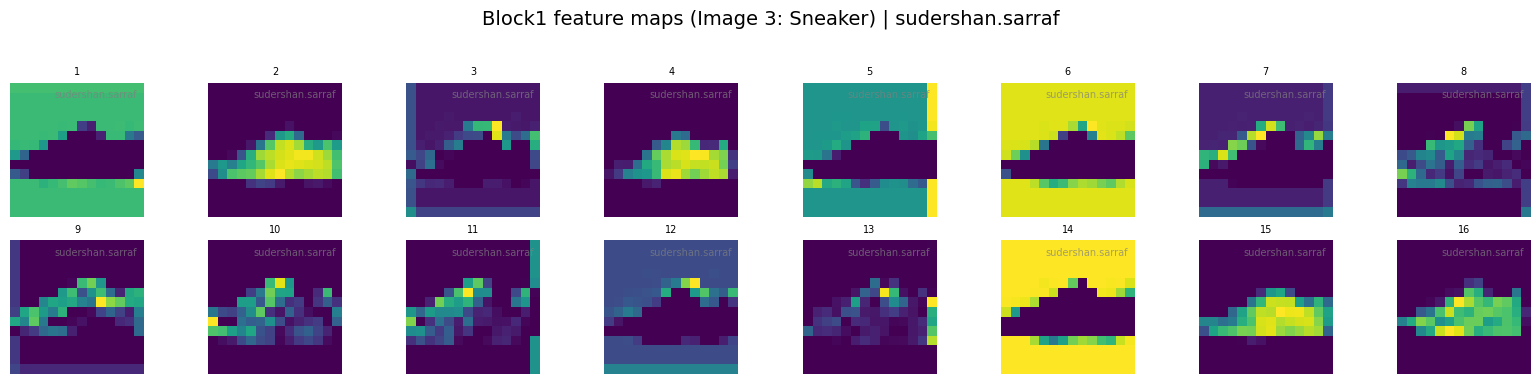

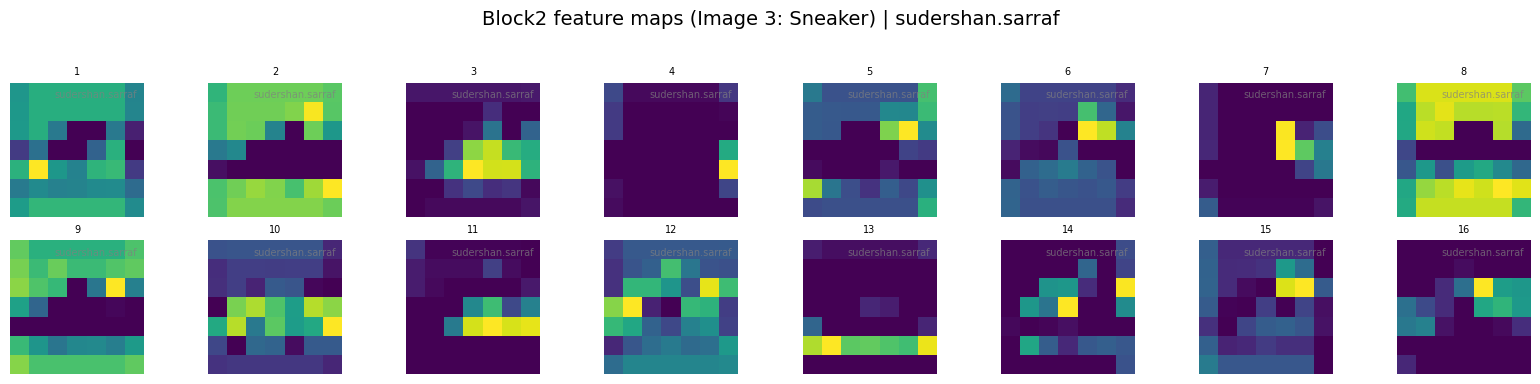

In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

# ----- Basic settings -----
USERNAME = "sudershan.sarraf"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

FASHION_MNIST_MEAN = 0.2860
FASHION_MNIST_STD  = 0.3530

BEST_CONFIG = {
    "learning_rate": 0.001,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 128,
    "dropout_rate": 0.3,
    "lambda_1": 1.0,
    "lambda_2": 2.0,
}

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# ----- Dataset definitions -----
class FashionMNISTMultiTask(Dataset):
    def __init__(self, root, train=True, transform=None, download=True):
        self.base_dataset = datasets.FashionMNIST(root=root, train=train, download=download)
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image_pil, class_label = self.base_dataset[idx]
        img_tensor_for_ink = self.to_tensor(image_pil)
        ink_target = img_tensor_for_ink.mean()
        image = self.transform(image_pil) if self.transform else img_tensor_for_ink
        return image, class_label, ink_target.float()

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((FASHION_MNIST_MEAN,), (FASHION_MNIST_STD,))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((FASHION_MNIST_MEAN,), (FASHION_MNIST_STD,))
])

print("Loading datasets...")
full_train_dataset = FashionMNISTMultiTask("./data", train=True, transform=train_transform, download=True)
test_dataset_custom = FashionMNISTMultiTask("./data", train=False, transform=val_test_transform, download=True)

train_size = int(0.9 * len(full_train_dataset))
val_size   = len(full_train_dataset) - train_size
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

class ValDatasetWrapper(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        self.base_dataset = subset.dataset.base_dataset
        self.to_tensor = subset.dataset.to_tensor

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        original_idx = self.subset.indices[idx]
        image_pil, class_label = self.base_dataset[original_idx]
        image_tensor = self.transform(image_pil)
        ink_target = self.to_tensor(image_pil).mean()
        return image_tensor, class_label, ink_target.float()

val_dataset = ValDatasetWrapper(val_subset, val_test_transform)

train_loader = DataLoader(train_subset, batch_size=BEST_CONFIG["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BEST_CONFIG["batch_size"], shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset_custom, batch_size=3, shuffle=True, num_workers=2, pin_memory=True)

# ----- Model -----
class MultiTaskCNN(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super().__init__()
        self.backbone = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, 3, padding=1),     # backbone.0
            nn.BatchNorm2d(32),                 # backbone.1
            nn.ReLU(),                          # backbone.2
            nn.MaxPool2d(2, 2),                 # backbone.3
            nn.Dropout(dropout_rate),           # backbone.4  <-- end Block 1

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),    # backbone.5
            nn.BatchNorm2d(64),                 # backbone.6
            nn.ReLU(),                          # backbone.7
            nn.MaxPool2d(2, 2),                 # backbone.8
            nn.Dropout(dropout_rate),           # backbone.9  <-- end Block 2
        )
        self.flatten = nn.Flatten()
        self.classification_head = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        self.regression_head = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        feats = self.backbone(x)
        feats = self.flatten(feats)
        return self.classification_head(feats), self.regression_head(feats)

model = MultiTaskCNN(dropout_rate=BEST_CONFIG["dropout_rate"]).to(device)

# ----- Training (no wandb) -----
crit_ce  = nn.CrossEntropyLoss()
crit_mse = nn.MSELoss()

if BEST_CONFIG["optimizer"].lower() == "adam":
    optimizer = optim.Adam(model.parameters(), lr=BEST_CONFIG["learning_rate"])
elif BEST_CONFIG["optimizer"].lower() == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=BEST_CONFIG["learning_rate"], momentum=0.9)
else:
    optimizer = optim.AdamW(model.parameters(), lr=BEST_CONFIG["learning_rate"])

best_val = float("inf")
best_state = None

print("\nTraining best-config model (λ1=1.0, λ2=2.0)...")
for epoch in range(BEST_CONFIG["epochs"]):
    model.train()
    train_total = 0.0
    for images, labels, inks in train_loader:
        images, labels, inks = images.to(device), labels.to(device), inks.to(device)

        optimizer.zero_grad()
        logits, reg_out = model(images)

        loss_ce  = crit_ce(logits, labels)
        loss_mse = crit_mse(reg_out.squeeze(), inks)
        loss     = BEST_CONFIG["lambda_1"] * loss_ce + BEST_CONFIG["lambda_2"] * loss_mse

        loss.backward()
        optimizer.step()
        train_total += loss.item()

    # quick val
    model.eval()
    val_total = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, inks in val_loader:
            images, labels, inks = images.to(device), labels.to(device), inks.to(device)
            logits, reg_out = model(images)
            loss_ce  = crit_ce(logits, labels)
            loss_mse = crit_mse(reg_out.squeeze(), inks)
            loss     = BEST_CONFIG["lambda_1"] * loss_ce + BEST_CONFIG["lambda_2"] * loss_mse
            val_total += loss.item()

            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    avg_train = train_total / len(train_loader)
    avg_val   = val_total / len(val_loader)
    acc       = 100.0 * correct / total
    print(f"Epoch {epoch+1:02d}/{BEST_CONFIG['epochs']}  "
          f"train_loss={avg_train:.4f}  val_loss={avg_val:.4f}  val_acc={acc:.2f}%")

    if avg_val < best_val:
        best_val = avg_val
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

if best_state is not None:
    model.load_state_dict(best_state)
model.eval()
print("Training complete. Using best-validation checkpoint.\n")

# ----- Feature map utils -----
def get_feature_maps(model, layer_name, x_bchw):
    feature_maps = {}
    target_layer = dict(model.named_modules()).get(layer_name)
    if target_layer is None:
        raise ValueError(f"Layer {layer_name} not found in model.")

    def hook_fn(module, inp, out):
        feature_maps[layer_name] = out.detach().cpu()

    handle = target_layer.register_forward_hook(hook_fn)
    with torch.no_grad():
        _ = model(x_bchw)
    handle.remove()
    return feature_maps[layer_name]  # [B,C,H,W]

def show_original(img_bchw, title):
    img = img_bchw[0].detach().cpu()           # [1,H,W]
    img = (img * FASHION_MNIST_STD + FASHION_MNIST_MEAN).clamp(0, 1)
    img = img.squeeze(0).numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap="gray")
    plt.title(f"{title} | {USERNAME}")
    plt.axis("off")
    plt.show()
    plt.close()

def visualize_maps(fmaps_bchw, title, max_channels=16, cols=8):
    maps = fmaps_bchw[0]  # [C,H,W]
    C = min(maps.shape[0], max_channels)
    rows = (C + cols - 1) // cols
    fig = plt.figure(figsize=(cols * 2, rows * 2))
    fig.suptitle(f"{title} | {USERNAME}", fontsize=14)
    for i in range(C):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(maps[i].numpy(), cmap="viridis")
        ax.axis("off")
        ax.text(0.95, 0.95, USERNAME, ha="right", va="top",
                transform=ax.transAxes, fontsize=7, color="gray", alpha=0.7)
        ax.set_title(f"{i+1}", fontsize=7)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()

# ----- Visualize on 3 random test images -----
images, labels, inks = next(iter(test_loader))
print("Visualizing feature maps for 3 test images...")

for i in range(3):
    x = images[i].unsqueeze(0).to(device)      # [1,1,28,28]
    y = class_names[labels[i].item()]

    print(f"\nImage {i+1}: {y}")
    show_original(x, title=f"Original ({y})")

    # AFTER Block 1 and Block 2 (what the assignment actually wants)
    fm_block1 = get_feature_maps(model, "backbone.4", x)
    visualize_maps(fm_block1, title=f"Block1 feature maps (Image {i+1}: {y})")

    fm_block2 = get_feature_maps(model, "backbone.9", x)
    visualize_maps(fm_block2, title=f"Block2 feature maps (Image {i+1}: {y})")
